In [3]:
import os

In [ ]:
import random
import numpy as np
import torch
import utils

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.utils.play import play

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing

Let's see what observations look like.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

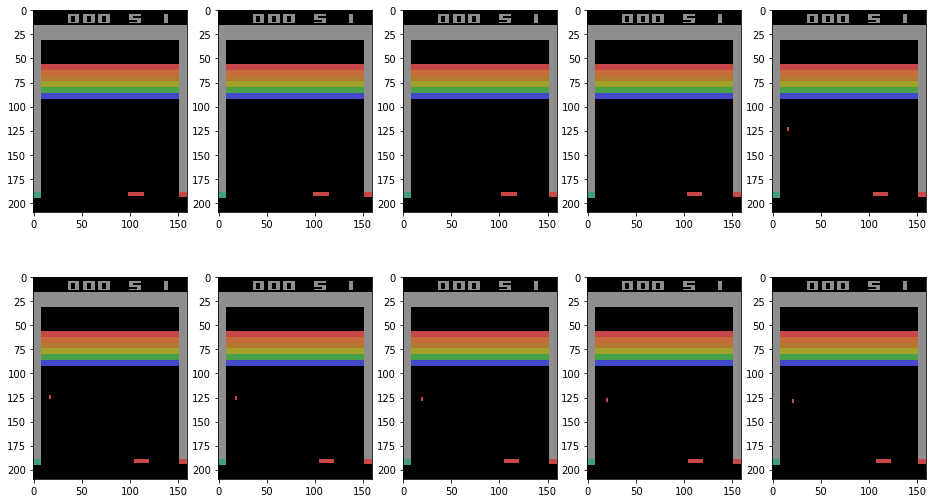

In [ ]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size, dtype=np.float32)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
        smaller = cv2.resize(gray, (64, 64))
        smaller_with_channel = np.reshape(smaller, self.img_size)
        return smaller_with_channel


    def observation(self, img):

        cropped = img[56:-16, 8:-8]
        grayed = self._to_gray_scale(cropped)
        finished = grayed.astype('float32') / 255
        
        return finished

Formal tests seem fine. Here's an example of what you'll get.


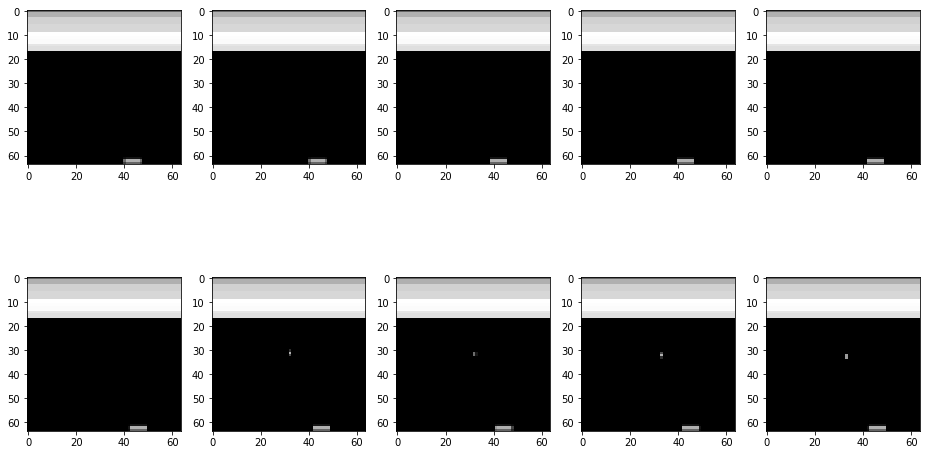

In [ ]:
import gym

env = gym.make(ENV_NAME)
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

In [ ]:
%load_ext autoreload
%autoreload 2
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):

    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.EpisodicLifeEnv(env)

    env = atari_wrappers.FireResetEnv(env)

    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    env = PreprocessAtariObs(env)
    return env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

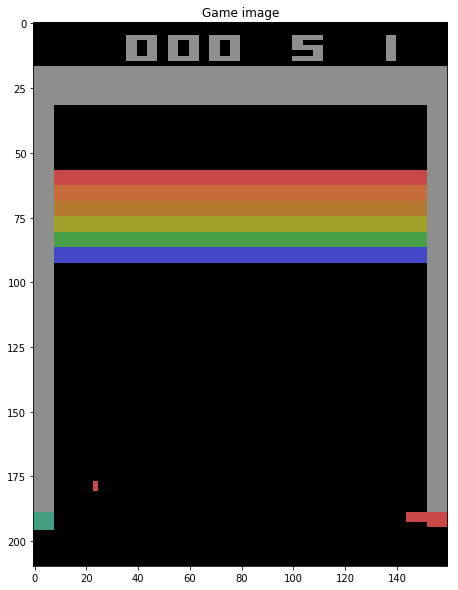

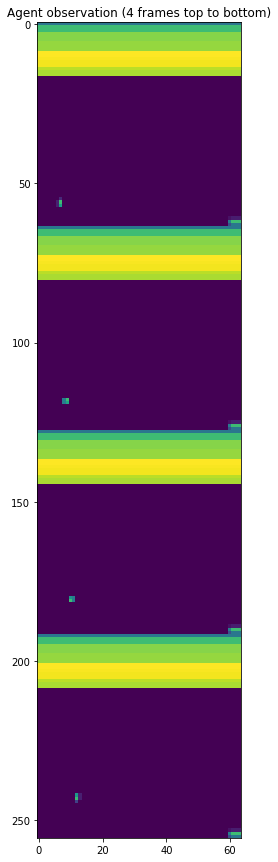

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape))
plt.show()

## DQN

In [2]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [ ]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.network = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        )
        

    def forward(self, state_t):
        qvalues = self.network(state_t)

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [ ]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
evaluate(env, agent, n_games=100)

### Experience replay

In [ ]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10

In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):

    s = initial_state
    sum_rewards = 0
        
    for t in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        
        next_s, r, done, _ = env.step(a)  
        exp_replay.add(s, a, r, next_s, done) 
        
        if done:
            s = env.reset()
        else: 
            s = next_s
            
        sum_rewards += r   

    return sum_rewards, s

In [ ]:
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

is_dones = list(zip(*exp_replay._storage))[-1]


for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)

### Target networks

In [ ]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

### Q-learning

In [ ]:
def init(cond, x, y):
    return (cond * x) + ((1-cond) * y)

In [ ]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    predicted_qvalues = agent(states)

    predicted_next_qvalues = target_network.forward(next_states)
    
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    next_state_values = torch.FloatTensor(torch.max(predicted_next_qvalues, dim=1)[0])

    target_qvalues_for_actions = rewards + gamma * next_state_values
    target_qvalues_for_actions = init(is_done, rewards, target_qvalues_for_actions)

    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

In [ ]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

## Main loop

In [ ]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

In [ ]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))







  0%|          | 8590/3000000 [06:50<43:05:38, 19.28it/s]

10000


In [ ]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [ ]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [ ]:
state = env.reset()

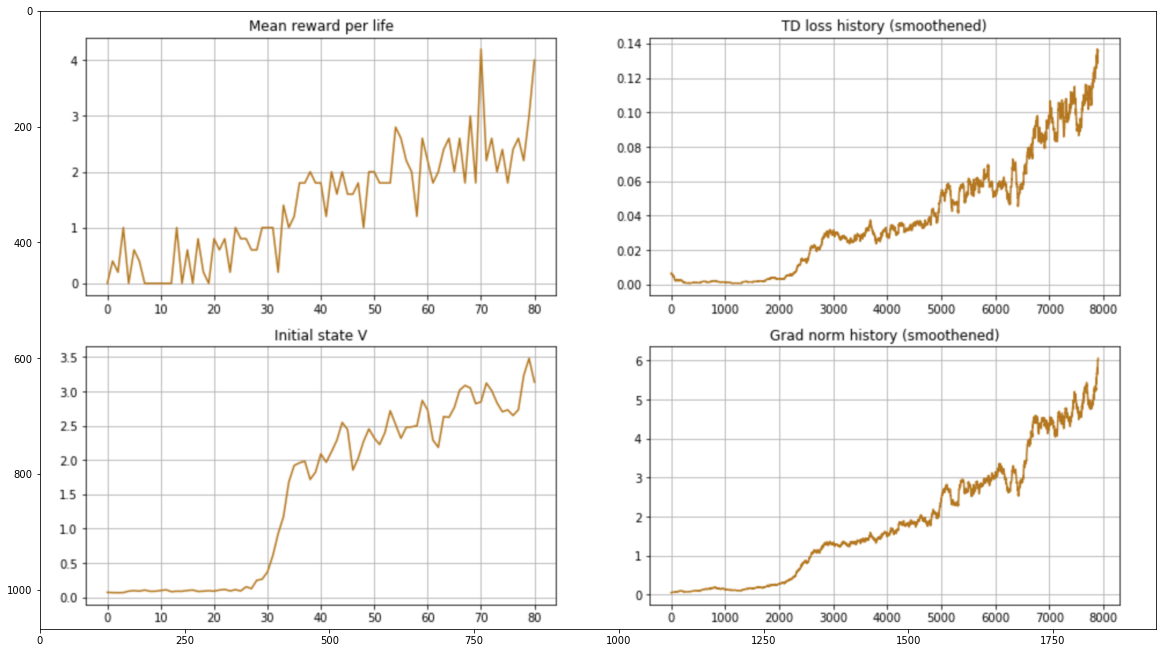

In [19]:
try:
    for step in range(total_steps):
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everythin is ok and make KeyboardInterrupt to continue')
            try:
                while True:
                    pass
            except KeyboardInterrupt:
                pass

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
        agent.train(True)

        loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, 
                               agent, target_network)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm)

        if step % refresh_target_network_freq == 0:
            target_network.parameters = agent.parameters

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                  (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()
except KeyboardInterrupt:
    pass

### Video

In [ ]:
# record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]
env_monitor.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-2]))  # this may or may not be _last_ video. Try other indices